In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [5]:
# Step 1: Import Required Libraries
import os
import zipfile
import urllib.request

# Step 2: Define URL and Download Location
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
local_zip_path = "/tmp/cats-and-dogs.zip"

# Step 3: Download the Dataset
print("Downloading dataset...")
urllib.request.urlretrieve(url, local_zip_path)
print("Download completed.")

# Step 4: Extract the Dataset
print("Extracting files...")
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/tmp')
print("Extraction completed.")

# Step 5: Count Images in Each Folder
cat_path = '/tmp/PetImages/Cat'
dog_path = '/tmp/PetImages/Dog'

# Some images might be corrupt, we can filter out those that are not readable later if needed
num_cats = len([name for name in os.listdir(cat_path) if os.path.isfile(os.path.join(cat_path, name))])
num_dogs = len([name for name in os.listdir(dog_path) if os.path.isfile(os.path.join(dog_path, name))])

print("Number of Cat images:", num_cats)
print("Number of Dog images:", num_dogs)


Download completed.
Extracting files...
Extraction completed.
Number of Cat images: 12501
Number of Dog images: 12501


In [6]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


11250
11250
1250
1250


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 22498 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [16]:
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
147/225 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.5552 - loss: 0.7552

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5764 - loss: 0.7227

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - accuracy: 0.5767 - loss: 0.7223 - val_accuracy: 0.7139 - val_loss: 0.5497
Epoch 2/15
 96/225 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.7014 - loss: 0.5724

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 197ms/step - accuracy: 0.7064 - loss: 0.5640 - val_accuracy: 0.7555 - val_loss: 0.5022
Epoch 3/15
167/225 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.7623 - loss: 0.4907

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 47s 210ms/step - accuracy: 0.7631 - loss: 0.4890 - val_accuracy: 0.7983 - val_loss: 0.4387
Epoch 4/15
 45/225 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - accuracy: 0.7869 - loss: 0.4441

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - accuracy: 0.7947 - loss: 0.4378 - val_accuracy: 0.8343 - val_loss: 0.3902
Epoch 5/15
 44/225 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.8098 - loss: 0.3938

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - accuracy: 0.8192 - loss: 0.3905 - val_accuracy: 0.8667 - val_loss: 0.3169
Epoch 6/15
142/225 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.8482 - loss: 0.3459

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step - accuracy: 0.8490 - loss: 0.3444 - val_accuracy: 0.8723 - val_loss: 0.2849
Epoch 7/15
 53/225 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.8795 - loss: 0.2880

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - accuracy: 0.8791 - loss: 0.2841 - val_accuracy: 0.9372 - val_loss: 0.1906
Epoch 8/15
 18/225 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - accuracy: 0.9348 - loss: 0.1967

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - accuracy: 0.9143 - loss: 0.2180 - val_accuracy: 0.9332 - val_loss: 0.1728
Epoch 9/15
173/225 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9456 - loss: 0.1553

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 198ms/step - accuracy: 0.9444 - loss: 0.1564 - val_accuracy: 0.9888 - val_loss: 0.0632
Epoch 10/15
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9705 - loss: 0.0859

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - accuracy: 0.9704 - loss: 0.0860 - val_accuracy: 0.9956 - val_loss: 0.0230
Epoch 11/15
133/225 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.9752 - loss: 0.0956

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.9757 - loss: 0.0947 - val_accuracy: 0.9976 - val_loss: 0.0134
Epoch 12/15
215/225 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9849 - loss: 0.0570

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.9847 - loss: 0.0583 - val_accuracy: 0.9992 - val_loss: 0.0103
Epoch 13/15
 76/225 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.9986 - loss: 0.0095

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step - accuracy: 0.9960 - loss: 0.0151 - val_accuracy: 0.9984 - val_loss: 0.0054
Epoch 14/15
 37/225 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step - accuracy: 0.9987 - loss: 0.0061

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.9916 - loss: 0.0338 - val_accuracy: 0.9296 - val_loss: 0.2153
Epoch 15/15
 23/225 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9841 - loss: 0.0610

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.9910 - loss: 0.0409 - val_accuracy: 0.9992 - val_loss: 0.0031


<Figure size 640x480 with 0 Axes>

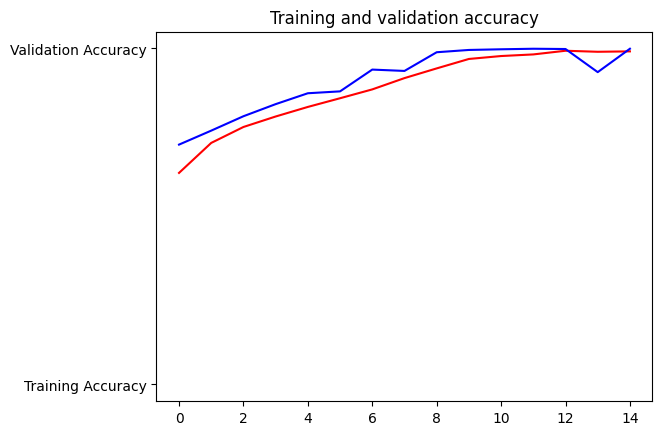

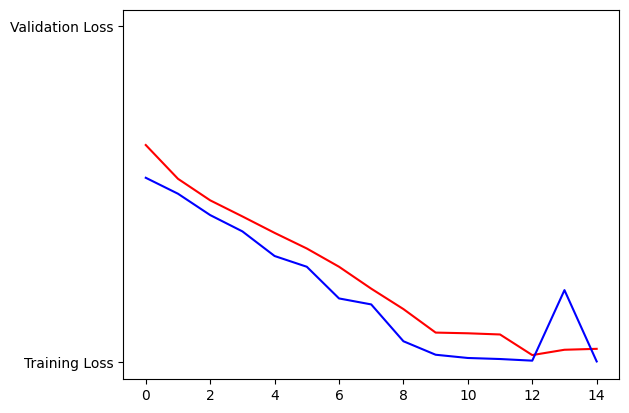

<Figure size 640x480 with 0 Axes>

In [17]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [22]:
#  You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving Cat_August_2010-4.jpg.webp to Cat_August_2010-4.jpg.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.]
Cat_August_2010-4.jpg.webp is a cat
